In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from utils import *
from component import Environment
from main import Config
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import binom

# Baseline: Fictitious Play Solving Two-Agents Dilemma
Payoff matrix:

| Tables      | Cooperation |  Defection |
|-------------|:-----------:|-----------:|
| Cooperation |   REWARD    | TEMPTATION |
| Defection   |   SUCKER    | PUNISHMENT |

In [3]:
N_EPISODES = 100
EPOCH = 100
seed = 42
np.random.seed(seed)

In [4]:
def two_agent_fictitious_play(payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, epsilon:float=0.05, random:bool=False):
    # exploration
    for i in range(1,10):
        strategy[i,0] = np.random.randint(0,2)
        strategy[i,1] = np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

    for i in range(10,N_EPISODES):
        # calculate payoff of Agent 0 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[i-1,1]*payoff[0,1] + (1-belief[i-1,1])*payoff[0,0]
        reward[1,0] = belief[i-1,1]*payoff[1,1] + (1-belief[i-1,1])*payoff[1,0]

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[i-1,0]*payoff[0,1] + (1-belief[i-1,0])*payoff[0,0]
        reward[1,1] = belief[i-1,0]*payoff[1,1] + (1-belief[i-1,0])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,0] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,0] = 0
        else:
            strategy[i,0] = strategy[i-1,0] if random==False else np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,1] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,1] = 0
        else:
            strategy[i,1] = strategy[i-1,1] if random==False else np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    return strategy, belief

In [5]:
# def generate_payoff_matrix(name:str, REWARD=3, TEMPTATION=None, SUCKER=None, PUNISHMENT=1, N=100):
#     # prisoner's dilemma rule: TEMPTATION > REWARD > PUNISHMENT > SUCKER; 2*REWARD > TEMPTATION + SUCKER
#     if REWARD is not None and TEMPTATION is not None and SUCKER is not None and PUNISHMENT is not None:
#         return REWARD, TEMPTATION, SUCKER, PUNISHMENT
#     if name == 'PD':
#         TEMPTATION = np.round(np.random.uniform(REWARD+0.01, 2*REWARD-0.01, N), decimals=2)
#         x = np.ones(N)
#         REWARD = REWARD * x
#         SUM = np.round(np.random.uniform(TEMPTATION, 2*REWARD-0.01, N), decimals=2)
#         SUCKER = SUM - TEMPTATION
#         PUNISHMENT = np.round(np.random.uniform(SUCKER+0.01, REWARD-0.01, N), decimals=2)
#         assert np.sum(TEMPTATION > REWARD) == N and np.sum(REWARD > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(TEMPTATION > REWARD)} and {np.sum(REWARD > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
#         assert np.sum(2*REWARD > TEMPTATION + SUCKER) == N, f'{np.sum(2*REWARD > TEMPTATION + SUCKER)}'
#         return REWARD, TEMPTATION, SUCKER, PUNISHMENT
#     if name == 'SH':
#         # stag hunt rule: REWARD > TEMPTATION > PUNISHMENT > SUCKER; TEMPTATION + SUCKER > 2*PUNISHMENT
#         x = np.ones(N)
#         PUNISHMENT = PUNISHMENT * x
#         SUCKER = np.round(np.random.uniform(0, PUNISHMENT-0.01, N), decimals=2)
#         TEMPTATION = np.round(np.random.uniform(2*PUNISHMENT-SUCKER+0.01, 10-0.01, N), decimals=2)
#         REWARD = np.round(np.random.uniform(TEMPTATION+0.01, 10, N), decimals=2)
#         assert np.sum(REWARD > TEMPTATION) == N and np.sum(TEMPTATION > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(REWARD > TEMPTATION)} and {np.sum(TEMPTATION > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
#         return REWARD, TEMPTATION, SUCKER, PUNISHMENT

def two_agent_simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT):
    # C:0, D:1
    df_result = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
        payoff = np.array([[R, S],[T, P]])
        strategy_list, belief_list = [],[]
        for ep in range(EPOCH):
            # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
            reward = np.zeros([2,2])
            # 'strategy' stores the strategy played in each time period
            strategy = -np.ones([N_EPISODES,2])
            # 'belief' stores the empirical distribution at each time period, which is the defection probability
            belief = np.zeros([N_EPISODES,2])
            strategy, belief = two_agent_fictitious_play(payoff, reward, strategy, belief, epsilon=0)
            strategy_list.append(strategy[-1].copy())
            belief_list.append(belief[-1].copy())
        df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief'])
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_result = pd.concat([df_result, df_mean], ignore_index=True)
    return df_result.astype(float)

PD results

1000it [02:04,  8.05it/s]


<AxesSubplot:ylabel='Frequency'>

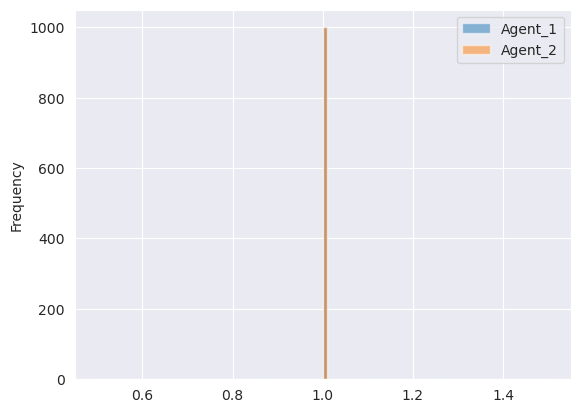

In [6]:
# prisoner's dilemma
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 5, 0, 1
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0
# payoff matrix for the two Agents in the 2x2 game
df_PD = two_agent_simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
df_PD[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

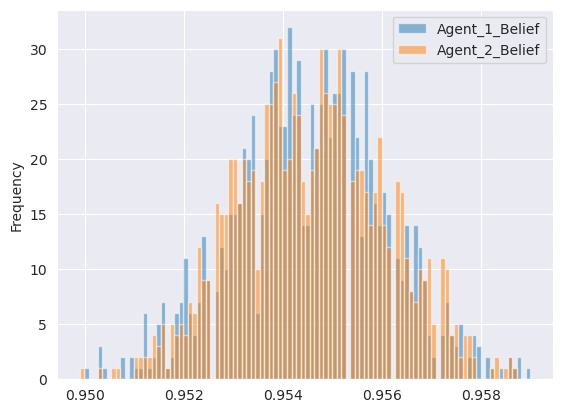

In [6]:
df_PD[['Agent_1_Belief', 'Agent_2_Belief']].plot.hist(bins=100, alpha=0.5)

Stag Hunt result

1000it [02:14,  7.41it/s]


<AxesSubplot:ylabel='Frequency'>

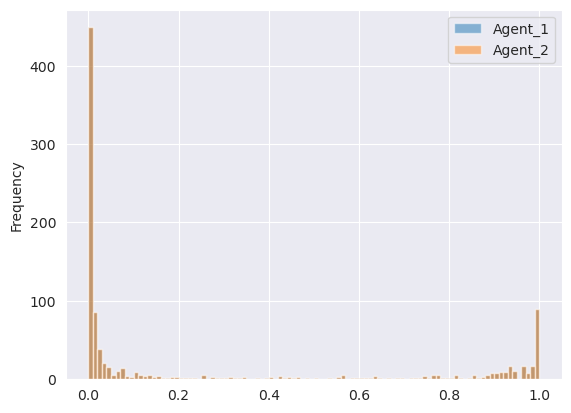

In [7]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1

df_SH = two_agent_simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
df_SH[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

Text(0, 0.5, '$\\mathbf{R+S-T-P}$')

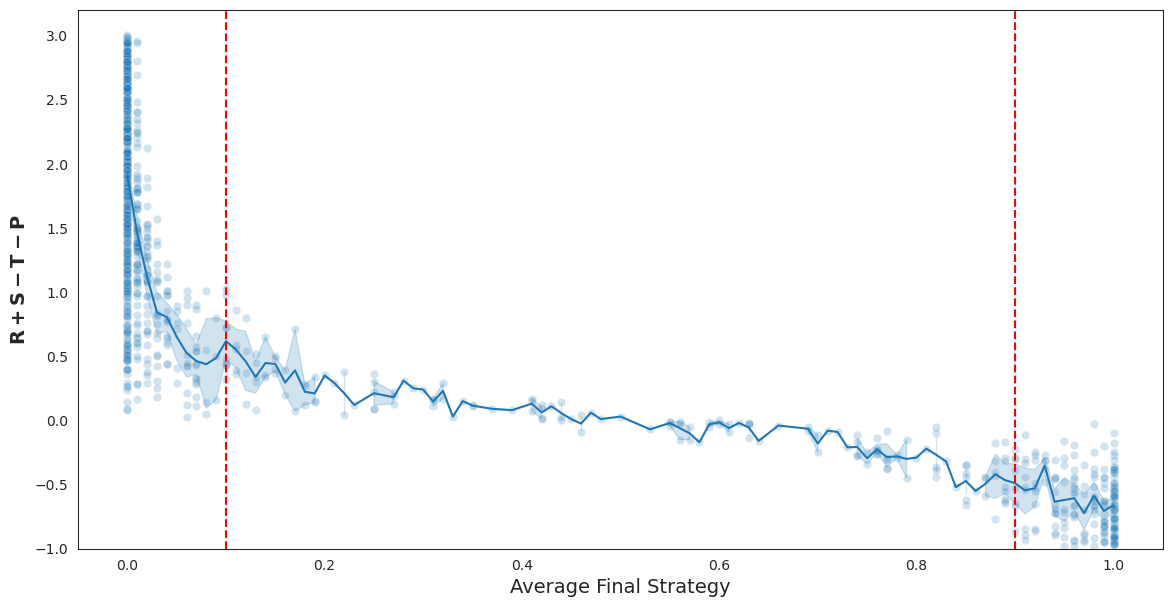

In [59]:
plt.figure(figsize=(14, 7))
df_SH['R+S-T-P'] = df_SH['reward'] + df_SH['sucker'] - df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='R+S-T-P')
sns.scatterplot(data=df_SH, x='Agent_1', y='R+S-T-P', alpha=0.2)
plt.vlines(0.1, -1, 10, 'r', '--')
plt.vlines(0.9, -1, 10, 'r', '--')
plt.ylim(-1,3.2)
plt.xlabel('Average Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S-T-P}$', fontsize=14)

In [53]:
rv = binom(10,0.5)
for i in range(11):
    print(rv.cdf(i))

0.0009765625
0.0107421875
0.0546875
0.171875
0.376953125
0.623046875
0.828125
0.9453125
0.9892578125
0.9990234375
1.0


In [49]:
R,T,S,P = 2, 1.5, -1, 0
n = 10
for i in range(n+1):
    if (R+S) * (1-i/n) > (T+P) * i/n:
        if (R+S) * (1-(i+1)/n) <= (T+P) * (i+1)/n:
           print(binom.cdf(i, n, 0.5), 1-binom.cdf(i, n, 0.5))

1.0 0.0
0.9 0.15
0.8 0.3
0.7 0.45
0.171875 0.828125


In [13]:
# n = 100
# df_SH_theor = pd.DataFrame(columns=['Cooperaion', 'Defection', 'temptation', 'reward', 'punishment', 'sucker'])
# for idx, val in tqdm(enumerate(REWARD)):
#     R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
#     for i in range(n+1):
#         if (R+S) * (1-i/n) > (T+P) * i/n:
#             if (R+S) * (1-(i+1)/n) <= (T+P) * (i+1)/n:
#                 df_SH_theor.loc[len(df_SH_theor.index)]=[binom.cdf(i, n, 0.5), 1-binom.cdf(i, n, 0.5), T,R,P,S]
#             if i == n:
#                 df_SH_theor.loc[len(df_SH_theor.index)]=[binom.cdf(i, n, 0.5), 1-binom.cdf(i, n, 0.5), T,R,P,S]
#         else:
#             if i == 0:
#                 df_SH_theor.loc[len(df_SH_theor.index)]=[binom.cdf(i, n, 0.5), 1-binom.cdf(i, n, 0.5), T,R,P,S]

n = 100
df_SH_theor = pd.DataFrame(columns=['Cooperaion', 'Defection', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
    for i in range(n+1):
        if (T-R) * (1-i/n) < (S-P) * i/n:
            if (T-R) * (1-(i+1)/n) >= (S-P) * (i+1)/n:
                df_SH_theor.loc[len(df_SH_theor.index)]=[binom.cdf(i, n, 0.5), 1-binom.cdf(i, n, 0.5), T,R,P,S]
            if i == n:
                df_SH_theor.loc[len(df_SH_theor.index)]=[binom.cdf(i, n, 0.5), 1-binom.cdf(i, n, 0.5), T,R,P,S]
        else:
            if i == 0:
                df_SH_theor.loc[len(df_SH_theor.index)]=[binom.cdf(i, n, 0.5), 1-binom.cdf(i, n, 0.5), T,R,P,S]

1000it [00:02, 436.39it/s]


Text(0, 0.5, '$\\mathbf{T-R/S-P}$')

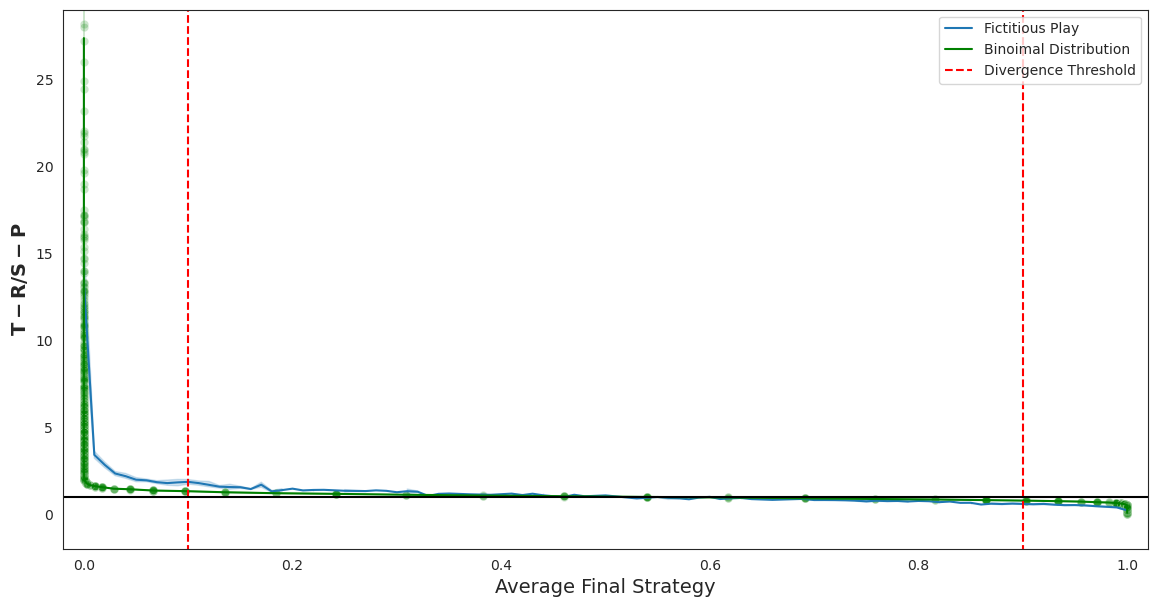

In [16]:
sns.set_style("white")
fig = plt.figure(figsize=(14, 7))
# df_SH['R+S/T+P'] = (df_SH['reward'] + df_SH['sucker']) / (df_SH['temptation'] + df_SH['punishment'])
# sns.lineplot(data=df_SH, x='Agent_1', y='R+S/T+P', label='Fictitious Play')
# # sns.scatterplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play', alpha=0.3)
# df_SH_theor['R+S/T+P'] = (df_SH_theor['reward'] + df_SH_theor['sucker']) / (df_SH_theor['temptation'] + df_SH_theor['punishment'])
# sns.lineplot(data=df_SH_theor, x='Defection', y='R+S/T+P',color='green', label='Binoimal Distribution')
# sns.scatterplot(data=df_SH_theor, x='Defection', y='R+S/T+P', alpha=0.2, color='green')

df_SH['T-R/S-P'] = (df_SH['temptation'] - df_SH['reward']) / (df_SH['sucker'] - df_SH['punishment'])
sns.lineplot(data=df_SH, x='Agent_1', y='T-R/S-P', label='Fictitious Play')
# sns.scatterplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play', alpha=0.3)
df_SH_theor['T-R/S-P'] = (df_SH_theor['temptation'] - df_SH_theor['reward']) / (df_SH_theor['sucker'] - df_SH_theor['punishment'])
sns.lineplot(data=df_SH_theor, x='Defection', y='T-R/S-P',color='green', label='Binoimal Distribution')
sns.scatterplot(data=df_SH_theor, x='Defection', y='T-R/S-P', alpha=0.2, color='green')

plt.vlines(0.1, -20, 50, 'r', '--', label='Divergence Threshold')
plt.vlines(0.9, -20, 50, 'r', '--')
plt.hlines(1, -0.1, 1.1, 'black', '-')
plt.legend()
plt.xlim(-0.02,1.02)
plt.ylim(-2,29)
# plt.ylim(-2,4)

plt.xlabel('Average Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{T-R/S-P}$', fontsize=14)
# fig.savefig('images/FP_SH_R+S_T+P.png', dpi=fig.dpi)

Text(0, 0.5, '$\\mathbf{R+S-T-P}$')

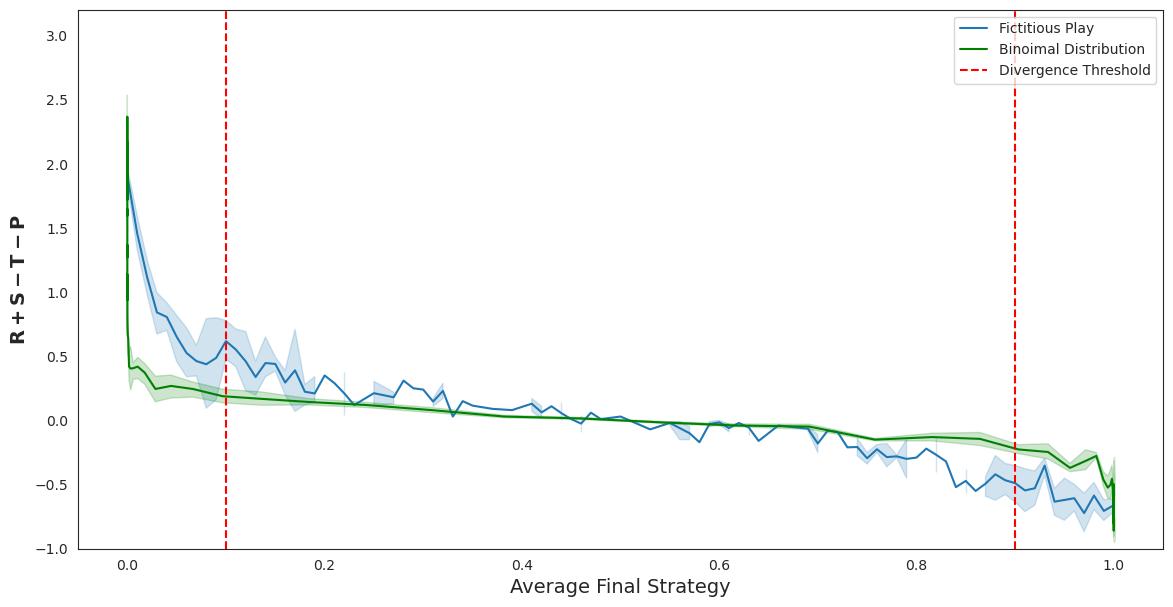

In [14]:
plt.figure(figsize=(14, 7))
df_SH['R+S-T-P'] = df_SH['reward'] + df_SH['sucker'] - df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play')
# sns.scatterplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play', alpha=0.3)
df_SH_theor['R+S-T-P'] = df_SH_theor['reward'] + df_SH_theor['sucker'] - df_SH_theor['temptation'] - df_SH_theor['punishment']
sns.lineplot(data=df_SH_theor, x='Defection', y='R+S-T-P',color='green', label='Binoimal Distribution')
# sns.scatterplot(data=df_SH_theor, x='Defection', y='R+S-T-P', label='Fictitious Play', alpha=0.3)
plt.vlines(0.1, -1, 10, 'r', '--', label='Divergence Threshold')
plt.vlines(0.9, -1, 10, 'r', '--')
plt.legend()
plt.ylim(-1,3.2)
plt.xlabel('Average Final Strategy', fontsize=14)
plt.ylabel(r'$\mathbf{R+S-T-P}$', fontsize=14)

<AxesSubplot:ylabel='Frequency'>

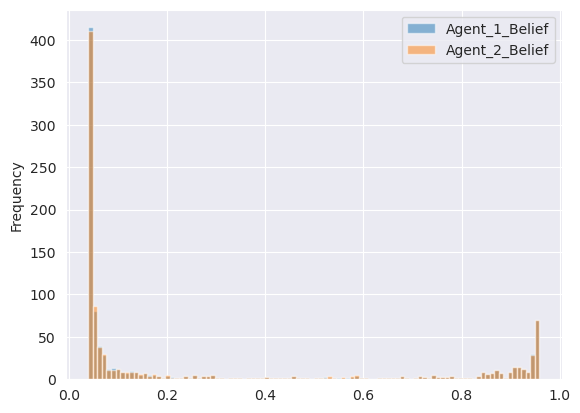

In [9]:
df_SH[['Agent_1_Belief', 'Agent_2_Belief']].plot.hist(bins=100, alpha=0.5)

Text(0, 0.5, '$\\mathbf{R+S}$')

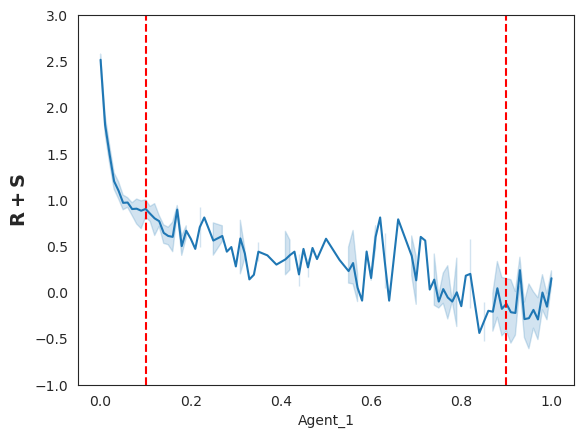

In [105]:
df_SH_convergent = df_SH.where((df_SH['Agent_1'] >= 0.9) | (df_SH['Agent_1'] <= 0.1)).dropna()
df_SH['R+S'] = df_SH['reward'] + df_SH['sucker']
sns.lineplot(data=df_SH, x='Agent_1', y='R+S')
plt.vlines(0.1, -1, 3.5, 'r', '--')
plt.vlines(0.9, -1, 3.5, 'r', '--')
plt.ylim(-1,3)
plt.ylabel(r'$\mathbf{R+S}$', fontsize=14)

Text(0, 0.5, '$\\mathbf{S/R}$')

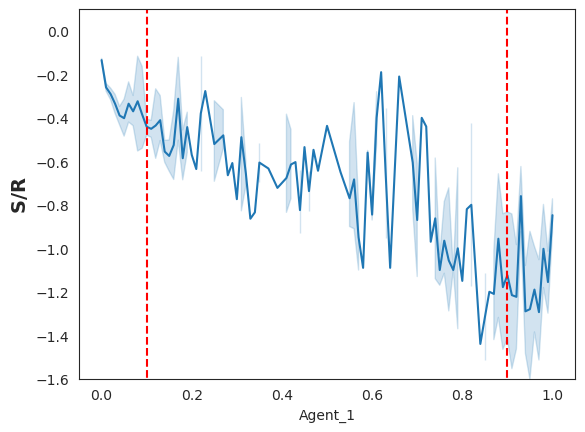

In [109]:
df_SH['S/R'] = df_SH['sucker'] / df_SH['reward']
sns.lineplot(data=df_SH, x='Agent_1', y='S/R')
plt.vlines(0.1, -10, 3.5, 'r', '--')
plt.vlines(0.9, -10, 3.5, 'r', '--')
plt.ylim(-1.6,.1)
plt.ylabel(r'$\mathbf{S/R}$', fontsize=14)

In [11]:
df_SH.where((df_SH['Agent_1'] < 0.9) & (df_SH['Agent_1'] > 0.1)).dropna()

,Agent_1,Agent_2,Agent_1_Belief,Agent_2_Belief,temptation,reward,punishment,sucker,R+S-T-P,R-T
4,0.59,0.59,0.580404,0.579091,0.04,1.00,0.0,-1.03,-0.07,0.96
15,0.88,0.88,0.841717,0.843939,0.38,1.00,0.0,-1.22,-0.60,0.62
18,0.88,0.88,0.842424,0.843939,0.15,1.00,0.0,-1.39,-0.54,0.85
24,0.11,0.11,0.147172,0.151010,0.12,1.53,0.0,-0.88,0.53,1.41
25,0.27,0.27,0.290909,0.293030,0.86,1.05,0.0,-0.14,0.05,0.19
...,...,...,...,...,...,...,...,...,...,...
987,0.23,0.23,0.256263,0.257677,0.31,1.30,0.0,-0.69,0.30,0.99
991,0.51,0.51,0.506061,0.507071,0.47,1.00,0.0,-0.63,-0.10,0.53
992,0.57,0.57,0.562828,0.563131,0.11,1.00,0.0,-1.01,-0.12,0.89
995,0.60,0.60,0.591919,0.590404,0.10,1.00,0.0,-0.99,-0.09,0.90


(-1.0, 2.0)

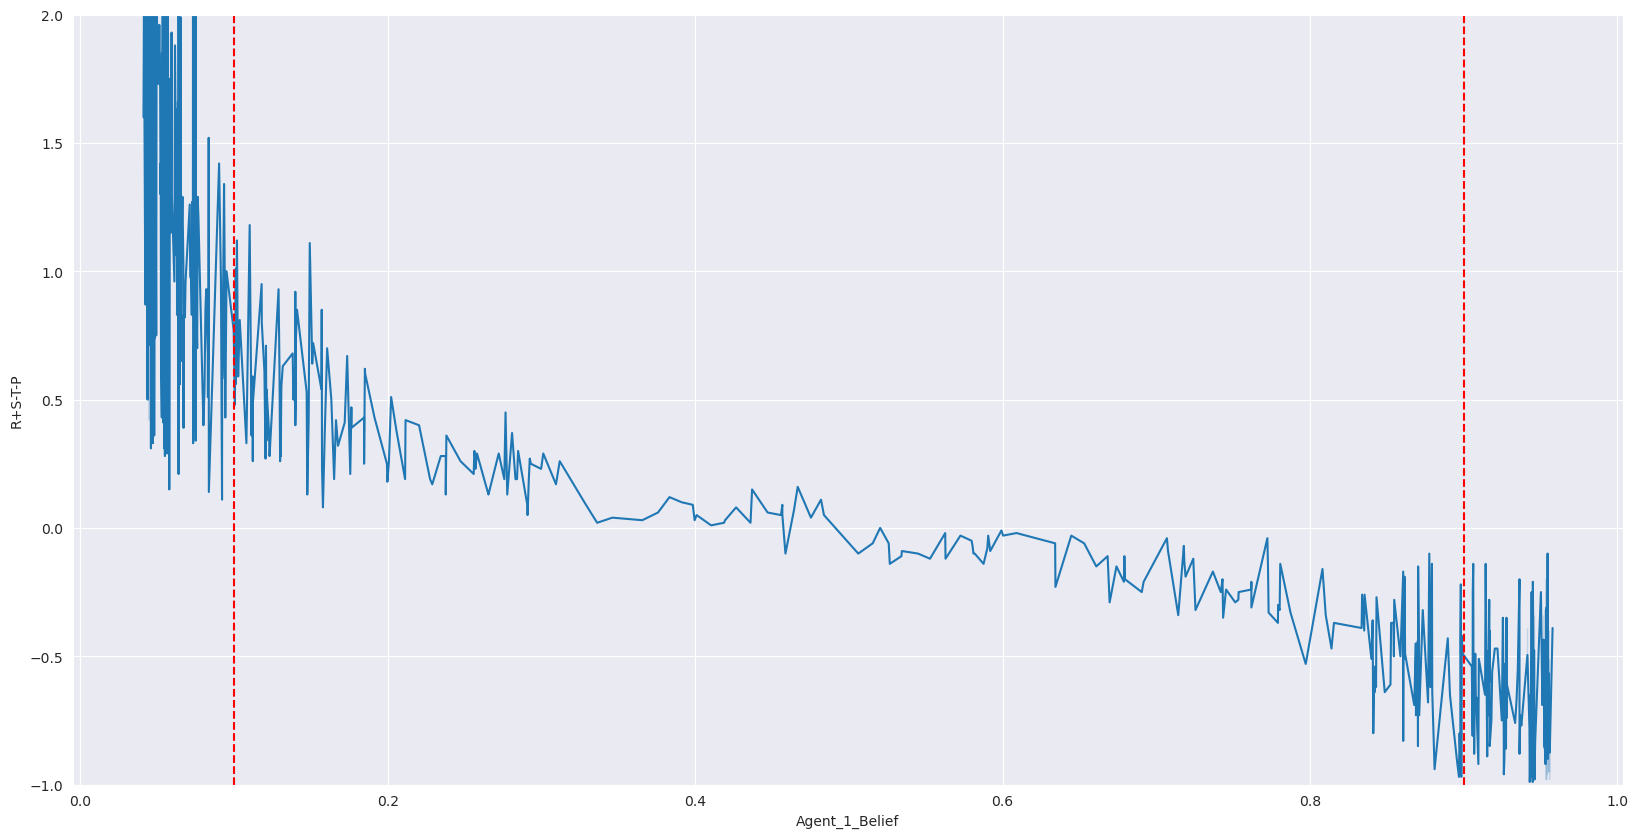

In [12]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_SH, x='Agent_1_Belief', y='R+S-T-P')
plt.vlines(0.1, -1, 3.5, 'r', '--')
plt.vlines(0.9, -1, 3.5, 'r', '--')
plt.ylim(-1,2)

(-0.5, 1.5)

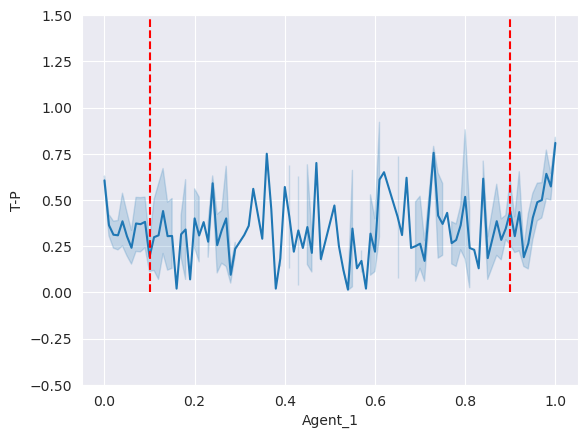

In [13]:
df_SH['T-P'] = df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='T-P')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(-0.5,1.5)

(0.0, 2.0)

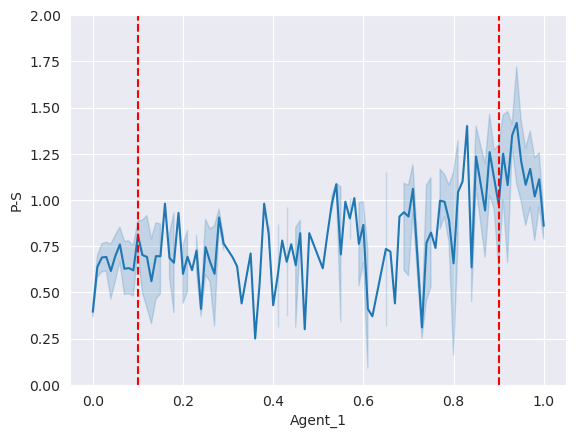

In [14]:
df_SH['P-S'] = df_SH['punishment'] - df_SH['sucker']
sns.lineplot(data=df_SH, x='Agent_1', y='P-S')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(0,2)

### Generalized into N-Agent Version

In [110]:
def multi_agent_fictitious_play(N_EPISODES:int, payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, N:int, alpha:float=0.05, epsilon:float=0.05, entropy_flag:bool=False):

    def entropy(p:float):
        return -np.sum(p * np.log(p + 1e-6))

    def random_select_partner(N:int, n:int):
        m = n
        while m == n:
            m = np.random.randint(0, N)
        return m

    def select_partner_entropy(N:int, n:int, belief:Type.TensorType):
        min_en = np.inf
        m = 0
        for i in range(N):
            if i == n:
                continue
            en = entropy(belief.copy()[i])
            if en < min_en:
                min_en= en
                m = i
        return m

    assert strategy.shape == (N_EPISODES, N), f"strategy columns should be {N}, but {strategy.shape}"

    log=dict()
    final_strategy = np.zeros(N)
    # exploration
    for i in range(1,10):
        n = np.random.randint(0, N)
        m = random_select_partner(N,n)

        strategy[i,n] = np.random.randint(0,2)
        strategy[i,m] = np.random.randint(0,2)

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}

    for i in range(10,N_EPISODES):
        n = np.random.randint(0, N)

        if entropy_flag:
            m = select_partner_entropy(N,n,belief)
        else:
            m = random_select_partner(N,n)

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[n]*payoff[0,1] + (1-belief[n])*payoff[0,0]
        reward[1,0] = belief[n]*payoff[1,1] + (1-belief[n])*payoff[1,0]

        # calculate payoff of Agent 2 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[m]*payoff[0,1] + (1-belief[m])*payoff[0,0]
        reward[1,1] = belief[m]*payoff[1,1] + (1-belief[m])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,n] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,n] = 0
        else:
            strategy[i,n] = np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,m] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,m] = 0
        else:
            strategy[i,m] = np.random.randint(0,2)

        print('error') if strategy[i,n]<0 or strategy[i,m]<0 else None

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}
        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    for i in range(N):
        j = -1
        while strategy[j,i] == -1:
            j -= 1
        final_strategy[i] = strategy[j,i]
    return strategy, belief, log, final_strategy

In [111]:
def multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=False):
    payoff = np.array([[REWARD, SUCKER],[TEMPTATION, PUNISHMENT]])
    strategy_list, belief_list = [],[]
    for ep in range(EPOCH):
        # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
        reward = np.zeros([2,2])
        # 'strategy' stores the strategy played in each time period
        strategy = -np.ones([N_EPISODES,N_AGENTS])
        # 'belief' stores the empirical distribution at each time period, which is the defection probability
        belief = np.zeros(N_AGENTS)
        _, belief, belief_log, final_strategy = multi_agent_fictitious_play(N_EPISODES, payoff, reward, strategy, belief, N_AGENTS, entropy_flag=entropy_flag)
        strategy_list.append(final_strategy.copy())
        belief_list.append(belief.copy())

    columns = []
    for i in range(N_AGENTS):
        columns.append(f'Agent_{i+1}')
    for i in range(N_AGENTS):
        columns.append(f'Agent_{i+1}_Belief')

    df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=columns)
    return df

random partner selection

In [17]:
# prisoner's dilemma
REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3.0, 5.8, 0.1, 3.3
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 4, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0

EPOCH = 100
N_AGENTS = 3
N_EPISODES = 1000
# C:0, D:1
# payoff matrix for the two players in the 2x2 game
df_multi_PD = multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N_AGENTS, EPOCH)
df_multi_PD.describe()

,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief
count,100.0,100.0,100.0,1.000000e+02,1.000000e+02,1.000000e+02
mean,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
std,0.0,0.0,0.0,2.079942e-15,1.815697e-15,1.979151e-15
min,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
50%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
75%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
max,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00


100it [03:56,  2.37s/it]


<AxesSubplot:ylabel='Frequency'>

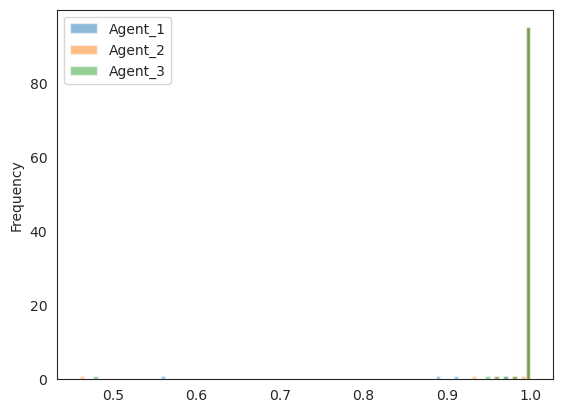

In [113]:
EPOCH = 100
N_AGENTS = 3
N_EPISODES = 1000
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
df_multi_PD = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
df_multi_PD = df_multi_PD.astype(float)
df_multi_PD[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

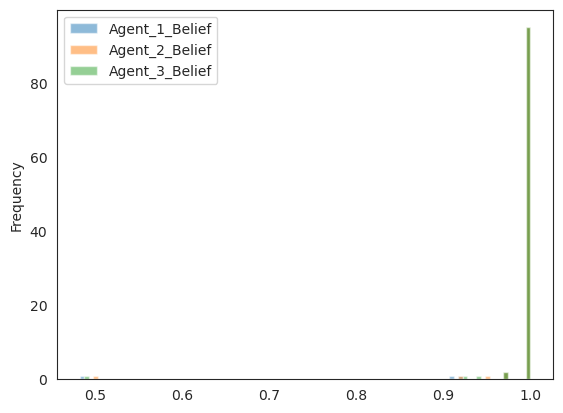

In [114]:
df_multi_PD[['Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief']].plot.hist(bins=100, alpha=0.5)

In [20]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    if sum(df_multi_PD['Agent_1'] < 0.9) >= 10 or sum(df_multi_PD['Agent_1_Belief'] < 0.9) >= 10:
        print(df_multi_PD.mean())

100it [03:44,  2.24s/it]
100it [03:39,  2.19s/it]
100it [03:37,  2.17s/it]
100it [03:36,  2.16s/it]
100it [03:34,  2.14s/it]
100it [03:33,  2.14s/it]


SH

In [115]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
df_multi_SH = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_SH = pd.concat([df_multi_SH, df_mean], ignore_index=True)
df_multi_SH = df_multi_SH.astype(float)
df_multi_SH.describe()

1000it [41:07,  2.47s/it]


,temptation,reward,punishment,sucker,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief
count,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.506870,2.097740,0.0,-0.629900,0.040510,0.041380,0.040580,4.050975e-02,4.147097e-02,4.061294e-02
std,0.286268,0.996452,0.0,0.398159,0.170422,0.171982,0.170144,1.704458e-01,1.721356e-01,1.701776e-01
min,0.010000,1.000000,0.0,-1.930000,0.000000,0.000000,0.000000,2.520841e-16,2.646062e-16,2.457898e-16
25%,0.250000,1.000000,0.0,-0.880000,0.000000,0.000000,0.000000,3.260982e-16,3.268406e-16,3.264645e-16
50%,0.520000,1.990000,0.0,-0.600000,0.000000,0.000000,0.000000,3.528199e-16,3.533848e-16,3.526587e-16
75%,0.760000,2.980000,0.0,-0.320000,0.000000,0.000000,0.000000,3.851757e-16,3.873123e-16,3.872716e-16
max,0.990000,4.000000,0.0,-0.010000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


<AxesSubplot:ylabel='Frequency'>

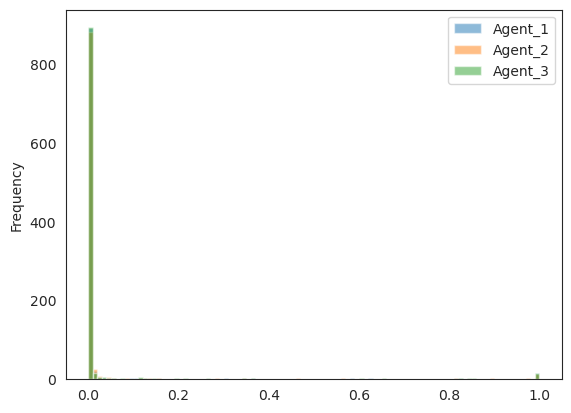

In [135]:
df_multi_SH[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

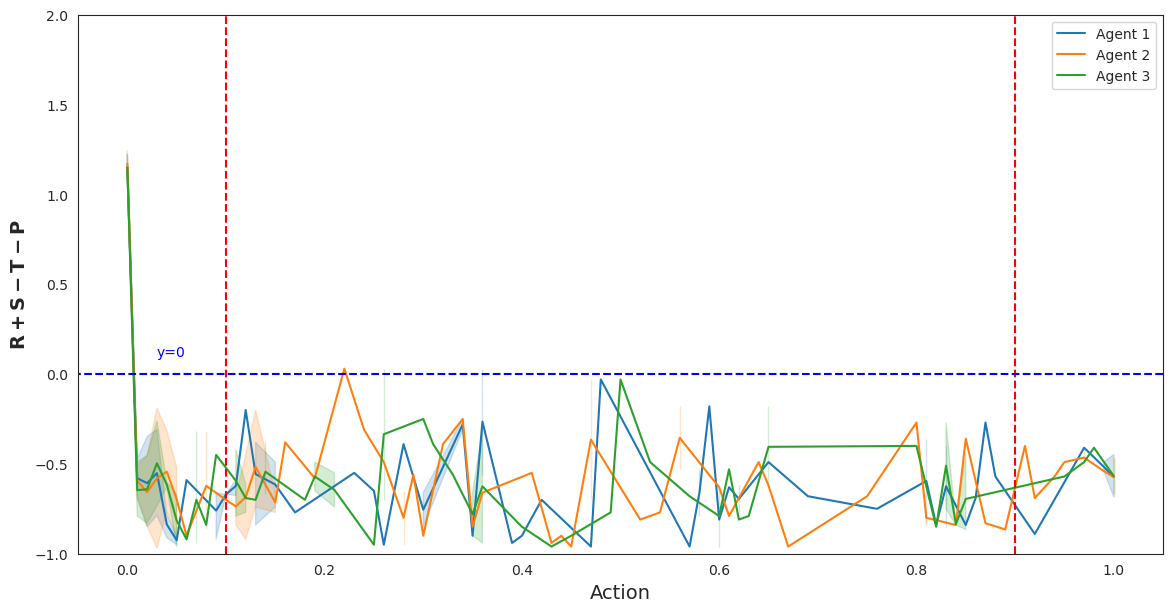

In [138]:
plt.figure(figsize=(14, 7))
df_multi_SH['R+S-T-P'] = df_multi_SH['reward'] + df_multi_SH['sucker'] - df_multi_SH['temptation'] - df_multi_SH['punishment']
sns.lineplot(data=df_multi_SH, x='Agent_1', y='R+S-T-P', label='Agent 1')
sns.lineplot(data=df_multi_SH, x='Agent_2', y='R+S-T-P', label='Agent 2')
sns.lineplot(data=df_multi_SH, x='Agent_3', y='R+S-T-P', label='Agent 3')
plt.vlines(0.1, -1, 10, 'r', '--')
plt.vlines(0.9, -1, 10, 'r', '--')
plt.hlines(0, -0.1, 1.1, 'b', '--')
plt.ylim(-1,2)
plt.xlim(-0.05,1.05)
plt.text(0.03, 0.1, "y=0", c='blue')
# plt.text(0.07, 2.5, "x=0.05", c='red')
# plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Action', fontsize=14)
plt.ylabel(r'$\mathbf{R+S-T-P}$', fontsize=14)
plt.legend()

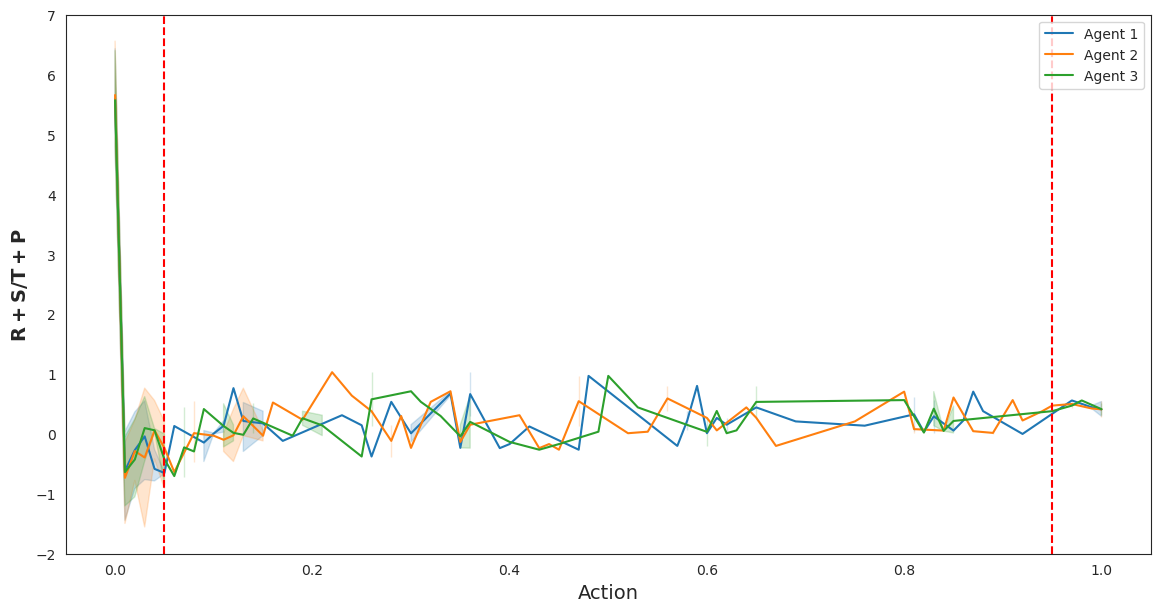

In [126]:
plt.figure(figsize=(14, 7))
df_multi_SH['R+S/T+P'] = (df_multi_SH['reward'] + df_multi_SH['sucker']) / (df_multi_SH['temptation'] + df_multi_SH['punishment'])
sns.lineplot(data=df_multi_SH, x='Agent_1', y='R+S/T+P', label='Agent 1')
sns.lineplot(data=df_multi_SH, x='Agent_2', y='R+S/T+P', label='Agent 2')
sns.lineplot(data=df_multi_SH, x='Agent_3', y='R+S/T+P', label='Agent 3')
plt.vlines(0.05, -2, 10, 'r', '--')
plt.vlines(0.95, -2, 10, 'r', '--')
# plt.hlines(0, -0.1, 1.1, 'b', '--')
plt.ylim(-2,7)
plt.xlim(-0.05,1.05)
plt.xlabel('Action', fontsize=14)
plt.ylabel(r'$\mathbf{R+S/T+P}$', fontsize=14)
plt.legend()

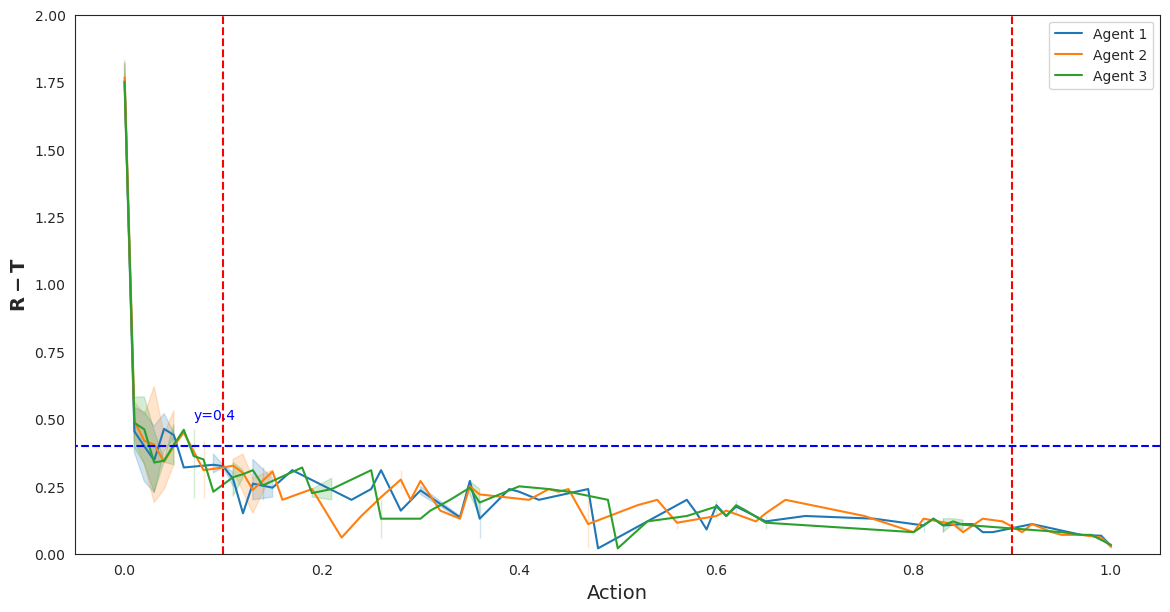

In [122]:
plt.figure(figsize=(14, 7))
df_multi_SH['R-T'] = df_multi_SH['reward'] - df_multi_SH['temptation']
sns.lineplot(data=df_multi_SH, x='Agent_1', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH, x='Agent_2', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH, x='Agent_3', y='R-T', label='Agent 3')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,2)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
# plt.text(0.07, 2.5, "x=0.05", c='red')
# plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Action', fontsize=14)
plt.ylabel(r'$\mathbf{R-T}$', fontsize=14)
plt.legend()

In [ ]:
plt.figure(figsize=(14, 7))
df_multi_SH['R-T'] = df_multi_SH['reward'] - df_multi_SH['temptation']
sns.lineplot(data=df_multi_SH, x='Agent_1_Belief', y='R-T', label='Agent 1 Belief')
sns.lineplot(data=df_multi_SH, x='Agent_2_Belief', y='R-T', label='Agent 2 Belief')
sns.lineplot(data=df_multi_SH, x='Agent_3_Belief', y='R-T', label='Agent 3 Belief')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Belief')
plt.legend()

Select partner according to entropy

100it [07:42,  4.62s/it]


<AxesSubplot:ylabel='Frequency'>

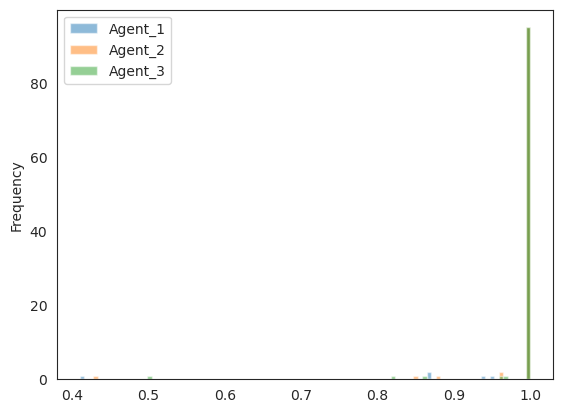

In [128]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
df_multi_PD_entropy = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=True)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_PD_entropy = pd.concat([df_multi_PD_entropy, df_mean], ignore_index=True)
df_multi_PD_entropy = df_multi_PD_entropy.astype(float)
df_multi_PD_entropy[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

In [129]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
df_multi_SH_entropy = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=True)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_SH_entropy = pd.concat([df_multi_SH_entropy, df_mean], ignore_index=True)
df_multi_SH_entropy = df_multi_SH_entropy.astype(float)

1000it [1:17:46,  4.67s/it]


<AxesSubplot:ylabel='Frequency'>

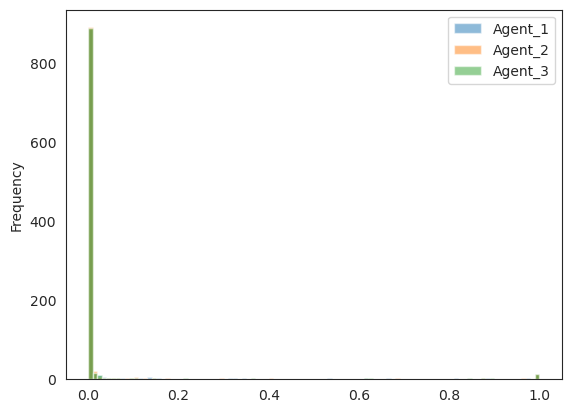

In [132]:
df_multi_SH_entropy[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

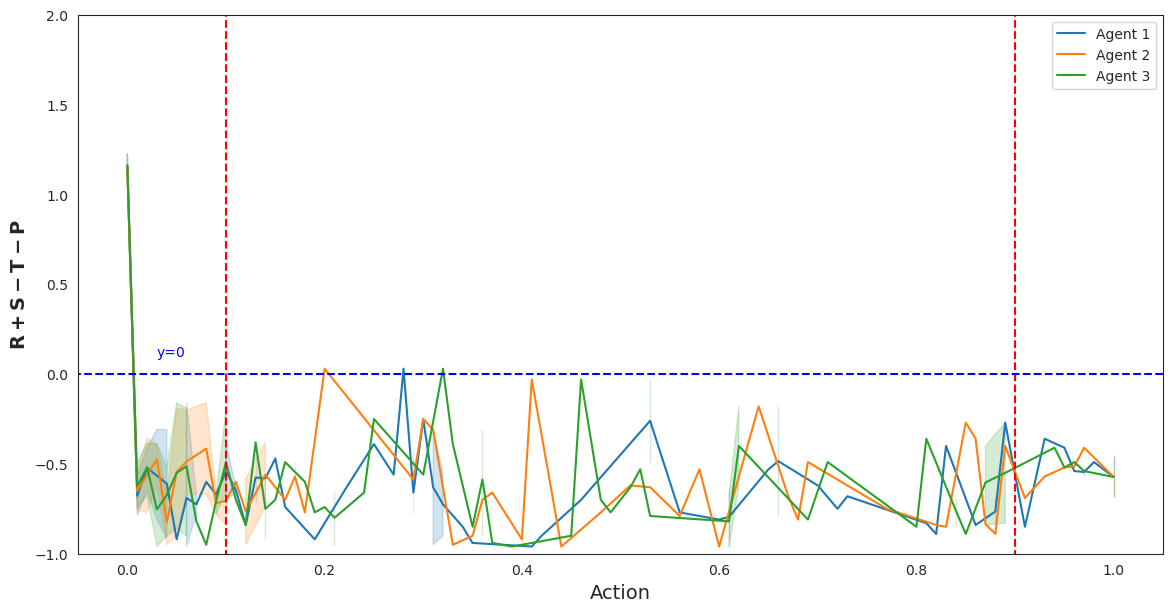

In [139]:
plt.figure(figsize=(14, 7))
df_multi_SH_entropy['R+S-T-P'] = df_multi_SH_entropy['reward'] + df_multi_SH_entropy['sucker'] - df_multi_SH_entropy['temptation'] - df_multi_SH_entropy['punishment']
sns.lineplot(data=df_multi_SH_entropy, x='Agent_1', y='R+S-T-P', label='Agent 1')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_2', y='R+S-T-P', label='Agent 2')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_3', y='R+S-T-P', label='Agent 3')
plt.vlines(0.1, -10, 10, 'r', '--')
plt.vlines(0.9, -10, 10, 'r', '--')
plt.hlines(0, -0.1, 1.1, 'b', '--')
plt.ylim(-1,2)
plt.xlim(-0.05,1.05)
plt.text(0.03, 0.1, "y=0", c='blue')
# plt.text(0.07, 2.5, "x=0.05", c='red')
# plt.text(0.88, 2.5, "x=0.95", c='red')
plt.legend()
plt.xlabel('Action', fontsize=14)
plt.ylabel(r'$\mathbf{R+S-T-P}$', fontsize=14)
plt.show()

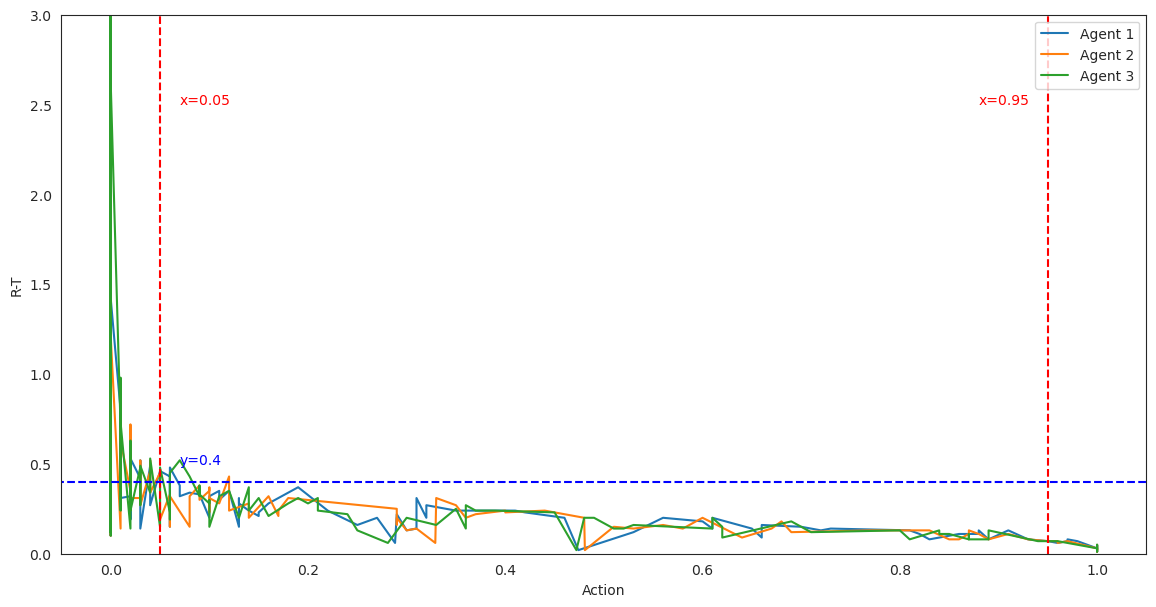

In [137]:
plt.figure(figsize=(14, 7))
df_multi_SH_entropy['R-T'] = df_multi_SH_entropy['reward'] - df_multi_SH_entropy['temptation']
sns.lineplot(data=df_multi_SH_entropy, x='Agent_1_Belief', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_2_Belief', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_3_Belief', y='R-T', label='Agent 3')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.legend()
plt.xlabel('Action')
plt.show()

In [29]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    print(df_multi_PD.mean())

100it [03:54,  2.35s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0503
Agent_2           0.0478
Agent_3           0.0486
Agent_4           0.0466
Agent_1_Belief    0.0503
Agent_2_Belief    0.0478
Agent_3_Belief    0.0486
Agent_4_Belief    0.0466
dtype: float64


100it [03:51,  2.32s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0431
Agent_2           0.0439
Agent_3           0.0446
Agent_4           0.0421
Agent_5           0.0445
Agent_1_Belief    0.0431
Agent_2_Belief    0.0439
Agent_3_Belief    0.0446
Agent_4_Belief    0.0421
Agent_5_Belief    0.0445
dtype: float64


100it [03:46,  2.27s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0394
Agent_2           0.0387
Agent_3           0.0412
Agent_4           0.0411
Agent_5           0.0406
Agent_6           0.0385
Agent_1_Belief    0.0394
Agent_2_Belief    0.0387
Agent_3_Belief    0.0412
Agent_4_Belief    0.0411
Agent_5_Belief    0.0406
Agent_6_Belief    0.0385
dtype: float64


100it [03:44,  2.25s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0381
Agent_2           0.0383
Agent_3           0.0392
Agent_4           0.0384
Agent_5           0.0392
Agent_6           0.0385
Agent_7           0.0389
Agent_1_Belief    0.0381
Agent_2_Belief    0.0383
Agent_3_Belief    0.0392
Agent_4_Belief    0.0384
Agent_5_Belief    0.0392
Agent_6_Belief    0.0385
Agent_7_Belief    0.0389
dtype: float64


100it [03:44,  2.24s/it]


temptation        0.529600
reward            1.933000
punishment        0.000000
sucker           -0.613700
Agent_1           0.036500
Agent_2           0.037300
Agent_3           0.036600
Agent_4           0.036400
Agent_5           0.036200
Agent_6           0.037600
Agent_7           0.035500
Agent_8           0.036800
Agent_1_Belief    0.036500
Agent_2_Belief    0.037300
Agent_3_Belief    0.036600
Agent_4_Belief    0.036400
Agent_5_Belief    0.036199
Agent_6_Belief    0.037600
Agent_7_Belief    0.035500
Agent_8_Belief    0.036800
dtype: float64


100it [03:43,  2.23s/it]

temptation        0.529600
reward            1.933000
punishment        0.000000
sucker           -0.613700
Agent_1           0.035800
Agent_2           0.034500
Agent_3           0.036500
Agent_4           0.034400
Agent_5           0.036300
Agent_6           0.035800
Agent_7           0.035400
Agent_8           0.035600
Agent_9           0.035600
Agent_1_Belief    0.035795
Agent_2_Belief    0.034491
Agent_3_Belief    0.036499
Agent_4_Belief    0.034400
Agent_5_Belief    0.036298
Agent_6_Belief    0.035799
Agent_7_Belief    0.035398
Agent_8_Belief    0.035599
Agent_9_Belief    0.035599
dtype: float64
